<a href="https://colab.research.google.com/github/capriate123/task/blob/main/GDGtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance numpy pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


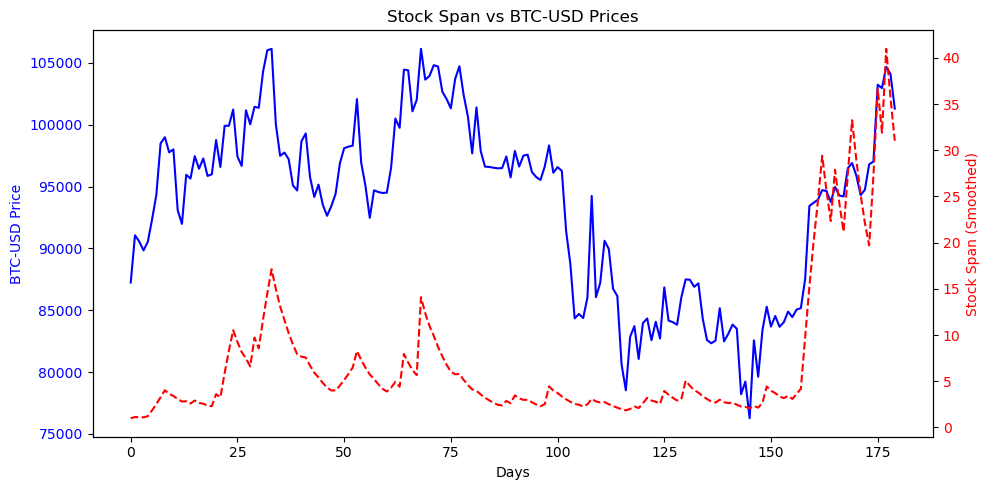

Support level (Min) from day 10 to 20: [91985.3203125]
Resistance level (Max) from day 10 to 20: [98768.53125]
Support level (Min) from day 50 to 100: [92484.0390625]
Resistance level (Max) from day 50 to 100: [106146.265625]
Updated the segment tree with a new BTC price.


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Download BTC-USD Data (Last 180 Days)
btc_data = yf.download('BTC-USD', period='180d')
closing_prices = btc_data['Close'].values

# Compute Stock Span using Stack (O(n))
span = np.zeros(len(closing_prices))
stack = []

for i in range(len(closing_prices)):
    while stack and closing_prices[stack[-1]] <= closing_prices[i]:
        stack.pop()
    span[i] = i + 1 if not stack else i - stack[-1]
    stack.append(i)

# Apply Exponential Moving Average (EMA) for Smoothing
span_smoothed = pd.Series(span).ewm(span=14, adjust=False).mean()
span_smoothed = np.maximum(span_smoothed, 1)

# Plot using Dual Y-Axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Days')
ax1.set_ylabel('BTC-USD Price', color='blue')
ax1.plot(closing_prices, color='blue', label='BTC-USD Closing Prices')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Stock Span (Smoothed)', color='red')
ax2.plot(span_smoothed, color='red', linestyle='dashed', label='Smoothed Stock Span')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Stock Span vs BTC-USD Prices')
fig.tight_layout()
plt.show()

# Segment Tree for Range Min (Support) & Max (Resistance) Queries
class SegmentTree:
    def __init__(self, arr):
        self.n = len(arr)
        self.tree = [(0, 0)] * (4 * self.n)  # (min, max)
        self.build(arr, 0, 0, self.n - 1)

    def build(self, arr, node, start, end):
        if start == end:
            self.tree[node] = (arr[start], arr[start])  # (min, max)
        else:
            mid = (start + end) // 2
            self.build(arr, 2 * node + 1, start, mid)
            self.build(arr, 2 * node + 2, mid + 1, end)
            min_val = min(self.tree[2 * node + 1][0], self.tree[2 * node + 2][0])
            max_val = max(self.tree[2 * node + 1][1], self.tree[2 * node + 2][1])
            self.tree[node] = (min_val, max_val)

    def update(self, index, value, node, start, end):
        if start == end:
            self.tree[node] = (value, value)
        else:
            mid = (start + end) // 2
            if index <= mid:
                self.update(index, value, 2 * node + 1, start, mid)
            else:
                self.update(index, value, 2 * node + 2, mid + 1, end)
            min_val = min(self.tree[2 * node + 1][0], self.tree[2 * node + 2][0])
            max_val = max(self.tree[2 * node + 1][1], self.tree[2 * node + 2][1])
            self.tree[node] = (min_val, max_val)

    def query(self, L, R, node, start, end):
        if R < start or L > end:
            return (float('inf'), float('-inf'))  # Return large min & small max
        if L <= start and end <= R:
            return self.tree[node]
        mid = (start + end) // 2
        left = self.query(L, R, 2 * node + 1, start, mid)
        right = self.query(L, R, 2 * node + 2, mid + 1, end)
        return (min(left[0], right[0]), max(left[1], right[1]))

# Initialize segment tree
segment_tree = SegmentTree(closing_prices)

# Example Queries
support, resistance = segment_tree.query(10, 20, 0, 0, len(closing_prices) - 1)
print(f"Support level (Min) from day 10 to 20: {support}")
print(f"Resistance level (Max) from day 10 to 20: {resistance}")

support, resistance = segment_tree.query(50, 100, 0, 0, len(closing_prices) - 1)
print(f"Support level (Min) from day 50 to 100: {support}")
print(f"Resistance level (Max) from day 50 to 100: {resistance}")

# Updating BTC price dynamically
new_price = 60000  # Example new BTC price
segment_tree.update(len(closing_prices) - 1, new_price, 0, 0, len(closing_prices) - 1)
print("Updated the segment tree with a new BTC price.")

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch BTC-USD data
def fetch_btcusd_data():
    """
    Downloads BTC-USD closing prices from Yahoo Finance for the period 2020-01-01 to 2023-01-01.
    Returns a list of closing prices.
    """
    btc = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01', progress=False)
    return btc['Close'].values.tolist()

# Segment Tree implementation
class SegmentTree:
    def __init__(self, max_size):
        """
        Initializes a Segment Tree with a given maximum size.

        Args:
            max_size (int): Maximum number of elements the tree can hold.
        """
        self.max_size = max_size
        self.tree_min = [float('inf')] * (4 * max_size)  # Min values for each node
        self.tree_max = [-float('inf')] * (4 * max_size)  # Max values for each node
        self.current_size = 0  # Current number of elements
        self.prices = [0] * max_size  # Array to store prices

    def build(self, arr, n):
        """
        Builds the segment tree with an initial array of prices.

        Args:
            arr (list): List of initial prices (floats).
            n (int): Number of elements to use from arr.
        """
        self.current_size = n
        for i in range(n):
            self.prices[i] = arr[i]
        self._build(0, 0, n - 1)

    def _build(self, node, start, end):
        """
        Recursive helper to build the segment tree.

        Args:
            node (int): Current node index.
            start (int): Start index of the segment.
            end (int): End index of the segment.
        """
        if start == end:
            self.tree_min[node] = self.prices[start]
            self.tree_max[node] = self.prices[start]
            return
        mid = (start + end) // 2
        self._build(2 * node + 1, start, mid)
        self._build(2 * node + 2, mid + 1, end)
        self.tree_min[node] = min(self.tree_min[2 * node + 1], self.tree_min[2 * node + 2])
        self.tree_max[node] = max(self.tree_max[2 * node + 1], self.tree_max[2 * node + 2])

    def update(self, price):
        """
        Updates the segment tree with a new price.

        Args:
            price (float): New price to add to the tree.

        Raises:
            ValueError: If price is not a float.
        """
        if not isinstance(price, float):
            raise ValueError(f"Expected float, got {type(price)}: {price}")
        idx = self.current_size
        self.prices[idx] = price
        self._update(0, 0, self.max_size - 1, idx)
        self.current_size += 1

    def _update(self, node, start, end, idx):
        """
        Recursive helper to update the segment tree.

        Args:
            node (int): Current node index.
            start (int): Start index of the segment.
            end (int): End index of the segment.
            idx (int): Index of the price to update.
        """
        if start == end:
            self.tree_min[node] = self.prices[idx]
            self.tree_max[node] = self.prices[idx]
            return
        mid = (start + end) // 2
        if start <= idx <= mid:
            self._update(2 * node + 1, start, mid, idx)
        else:
            self._update(2 * node + 2, mid + 1, end, idx)
        self.tree_min[node] = min(self.tree_min[2 * node + 1], self.tree_min[2 * node + 2])
        self.tree_max[node] = max(self.tree_max[2 * node + 1], self.tree_max[2 * node + 2])

    def query_min(self, L, R):
        """
        Queries the minimum price in the range [L, R].

        Args:
            L (int): Left bound of the query range.
            R (int): Right bound of the query range.

        Returns:
            float: Minimum price in the range.
        """
        return self._query_min(0, 0, self.max_size - 1, L, R)

    def _query_min(self, node, start, end, L, R):
        """
        Recursive helper to query the minimum price.

        Args:
            node (int): Current node index.
            start (int): Start index of the segment.
            end (int): End index of the segment.
            L (int): Left bound of the query range.
            R (int): Right bound of the query range.

        Returns:
            float: Minimum price in the overlapping range.
        """
        if R < start or L > end:
            return float('inf')
        if L <= start and R >= end:
            return self.tree_min[node]
        mid = (start + end) // 2
        left_min = self._query_min(2 * node + 1, start, mid, L, R)
        right_min = self._query_min(2 * node + 2, mid + 1, end, L, R)
        return min(left_min, right_min)

    def query_max(self, L, R):
        """
        Queries the maximum price in the range [L, R].

        Args:
            L (int): Left bound of the query range.
            R (int): Right bound of the query range.

        Returns:
            float: Maximum price in the range.
        """
        return self._query_max(0, 0, self.max_size - 1, L, R)

    def _query_max(self, node, start, end, L, R):
        """
        Recursive helper to query the maximum price.

        Args:
            node (int): Current node index.
            start (int): Start index of the segment.
            end (int): End index of the segment.
            L (int): Left bound of the query range.
            R (int): Right bound of the query range.

        Returns:
            float: Maximum price in the overlapping range.
        """
        if R < start or L > end:
            return -float('inf')
        if L <= start and R >= end:
            return self.tree_max[node]
        mid = (start + end) // 2
        left_max = self._query_max(2 * node + 1, start, mid, L, R)
        right_max = self._query_max(2 * node + 2, mid + 1, end, L, R)
        return max(left_max, right_max)

# Simulate trading with segment tree
def simulate_trading(prices):
    """
    Simulates a trading strategy using a segment tree to track support and resistance levels.

    Args:
        prices (list): List of BTC-USD closing prices (floats).
    """
    N = 100  # Number of initial prices to build the tree
    seg_tree = SegmentTree(2 * 10**5)  # Max size for N + subsequent updates
    seg_tree.build(prices[:N], N)

    portfolio = 0  # BTC holdings
    cash = 10000  # USD starting cash
    actions = []  # List to store buy/sell actions

    # Process remaining prices as updates
    for i in range(N, len(prices)):
        current_price = prices[i]
        seg_tree.update(current_price)
        # Query support and resistance for the last 50 days
        L = max(0, i - 49)
        R = i
        support = seg_tree.query_min(L, R)
        resistance = seg_tree.query_max(L, R)

        # Trading strategy
        if current_price <= support * 1.02:  # Buy if price is within 2% above support
            if cash >= current_price:
                portfolio += cash / current_price
                cash = 0
                actions.append(f"Day {i}: Buy at {current_price:.2f}, Support: {support:.2f}")
        elif current_price >= resistance * 0.98:  # Sell if price is within 2% below resistance
            if portfolio > 0:
                cash += portfolio * current_price
                portfolio = 0
                actions.append(f"Day {i}: Sell at {current_price:.2f}, Resistance: {resistance:.2f}")

    # Calculate final portfolio value
    final_value = cash + portfolio * prices[-1]
    print(f"Final Portfolio Value: ${final_value:.2f}")
    # Print last 5 actions
    for action in actions[-5:]:
        print(action)

# Main execution
if __name__ == "__main__":
    # Fetch the data
    prices = fetch_btcusd_data()
    # Ensure prices is a list of floats, extracting from single-element lists if necessary
    prices = [p[0] if isinstance(p, list) and len(p) == 1 and isinstance(p[0], float) else p for p in prices]
    # Run the trading simulation
    simulate_trading(prices)

Final Portfolio Value: $12505.20
Day 106: Sell at 7116.80, Resistance: 7116.80
Day 196: Buy at 9192.84, Support: 9045.39
Day 206: Sell at 9677.11, Resistance: 9870.09
Day 266: Buy at 10246.19, Support: 10131.52
Day 292: Sell at 11742.04, Resistance: 11970.48
